<a href="https://colab.research.google.com/github/Neo-glitch/computer-vision-masterclass/blob/main/Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyforest

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pyforest: filename=pyforest-1.1.0-py2.py3-none-any.whl size=14607 sha256=f4868626cdef3d28898b5c3213102baae5f4902a55220dfeea136d6588417931
  Stored in directory: /root/.cache/pip/wheels/21/2d/19/8b5488f0caea6d892333413745640532d40d70e6b5351d7633
Successfully built pyforest


In [1]:
# import pyforest
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# load pretrained model without the dense layers
network = tf.keras.applications.VGG19(include_top = False, weights = "imagenet")

network.summary()

80134624/80134624 [==============================] - 4s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

In [3]:
len(network.layers)

22

**Content Image**

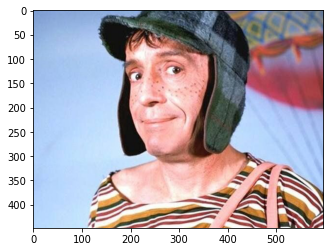

In [4]:
content_image = tf.keras.preprocessing.image.load_img("/content/drive/MyDrive/Computer Vision Masterclass Files/Images/chaves.jpeg")
plt.imshow(content_image)

In [5]:
# converts image from PIL format to np format for easier operation
content_image = tf.keras.preprocessing.image.img_to_array(content_image)

print(content_image.shape, content_image.max(), content_image.min())


# normalize image
content_image = content_image / 255.

print(content_image.max(), content_image.min())

(448, 598, 3) 255.0 0.0
1.0 0.0


In [6]:
# set image in batch_format
content_image = tf.expand_dims(content_image, axis= 0)    # could have used content_image[tf.new_axis, ...]
content_image.shape

TensorShape([1, 448, 598, 3])

**Style Image**

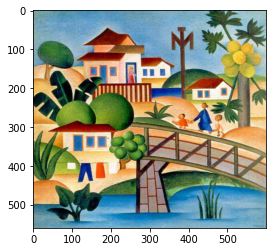

In [7]:
style_image = tf.keras.preprocessing.image.load_img("/content/drive/MyDrive/Computer Vision Masterclass Files/Images/tarsila_amaral.jpg")
plt.imshow(style_image)

In [8]:
style_image = tf.keras.preprocessing.image.img_to_array(style_image)
style_image = style_image / 255.
style_image = style_image[tf.newaxis, ...]

style_image.shape

# seen that style image and content image have diff shape, better to have both be in same shape for faster processing

(1, 560, 600, 3)

**Building the NN**

In [9]:
# these layers are constant for style transfer using vgg
content_layers = ["block4_conv2"]
style_layers = ["block1_conv1", "block2_conv1", "block3_conv1", "block4_conv1", "block5_conv1"]

In [10]:
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [11]:
def vgg_layers(layer_names):
  vgg = tf.keras.applications.VGG19(include_top = False, weights="imagenet")
  vgg.trainable = False  # freeze pretrained layers


  # gets activations of the layer names passed and store in a list
  outputs = [vgg.get_layer(name).output for name in layer_names]
  network = tf.keras.Model(inputs = [vgg.input], outputs = outputs)

  return network

In [12]:
style_extractor = vgg_layers(style_layers)

style_extractor.outputs  # our model for style transfer has five outputs

[<KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'block1_conv1')>,
 <KerasTensor: shape=(None, None, None, 128) dtype=float32 (created by layer 'block2_conv1')>,
 <KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'block3_conv1')>,
 <KerasTensor: shape=(None, None, None, 512) dtype=float32 (created by layer 'block4_conv1')>,
 <KerasTensor: shape=(None, None, None, 512) dtype=float32 (created by layer 'block5_conv1')>]

In [13]:
style_outputs = style_extractor(style_image)

print(style_outputs[0].shape)
style_outputs[0]   # activation values of 1st output layer out of 5

(1, 560, 600, 64)


<tf.Tensor: shape=(1, 560, 600, 64), dtype=float32, numpy=
array([[[[0.0000000e+00, 1.1168056e-01, 6.2121809e-02, ...,
          4.7374946e-01, 4.9520522e-01, 1.5619564e-01],
         [0.0000000e+00, 2.1199909e-01, 3.7911364e-01, ...,
          1.7614037e-01, 1.4901578e+00, 1.1453360e+00],
         [0.0000000e+00, 2.0160642e-01, 3.8564062e-01, ...,
          1.3608325e-01, 1.5308917e+00, 1.1796422e+00],
         ...,
         [0.0000000e+00, 3.3286181e-01, 5.1675826e-01, ...,
          0.0000000e+00, 1.6993666e+00, 1.3342988e+00],
         [0.0000000e+00, 3.4320116e-01, 5.2286661e-01, ...,
          0.0000000e+00, 1.7050551e+00, 1.3393183e+00],
         [7.8187567e-01, 4.2259818e-01, 7.7565944e-01, ...,
          4.4906515e-01, 2.4665630e+00, 2.3771269e+00]],

        [[0.0000000e+00, 1.1404040e-01, 0.0000000e+00, ...,
          7.9952955e-02, 0.0000000e+00, 0.0000000e+00],
         [6.3841367e-01, 2.4004281e-01, 3.5869697e-01, ...,
          0.0000000e+00, 5.8317912e-01, 7.0515585e-01

In [14]:
"""
  gram matrix to det loss between generated image and style image
  and aim is to minimize loss between generated image and style image
  and this is done for every of our output layer independently
"""
def gram_matrix(layer_activation):

  # do dot product and contract the output dim
  result = tf.linalg.einsum("bijc, bijd -> bcd", layer_activation, layer_activation)
  input_shape = tf.shape(layer_activation)
  # multiply height and width
  num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)

  return result / num_locations   # normalize activations so all output layer will be in same scale

In [15]:
gram_matrix(style_outputs[0])

<tf.Tensor: shape=(1, 64, 64), dtype=float32, numpy=
array([[[0.6311029 , 0.2894989 , 0.28517216, ..., 0.10518257,
         0.36955732, 0.45017174],
        [0.2894989 , 0.24226913, 0.18415499, ..., 0.03151667,
         0.19604628, 0.21700144],
        [0.28517216, 0.18415499, 0.16761069, ..., 0.02775798,
         0.19407696, 0.22697598],
        ...,
        [0.10518257, 0.03151667, 0.02775798, ..., 0.08261996,
         0.06934635, 0.06635   ],
        [0.36955732, 0.19604628, 0.19407696, ..., 0.06934635,
         0.2869287 , 0.3186244 ],
        [0.45017174, 0.21700144, 0.22697598, ..., 0.06635   ,
         0.3186244 , 0.37485752]]], dtype=float32)>

In [16]:
# define our style transfer model
class StyleContentModel(tf.keras.models.Model):

  def __init__(self, style_layers, content_layers):
    super().__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False  # freeze the layers during training


  # called when fit our model. and input is image
  def call(self, inputs):
    inputs = inputs * 255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs) # preprocess image to vgg form needed
    outputs = self.vgg(preprocessed_input)

    # get activations of style layers and content layers sepeartely
    style_outputs = outputs[:self.num_style_layers]
    content_outputs = outputs[self.num_style_layers:]

    style_outputs = [gram_matrix(style_output) for style_output in style_outputs]

    content_dict = {content_name: value for content_name, value in zip(self.content_layers, content_outputs)}
    style_dict = {style_name: value for style_name, value in zip(self.style_layers, style_outputs)}

    return {"content": content_dict, "style": style_dict}

In [17]:
# just to view the output(activations) being returned from our model for content and style image
extractor = StyleContentModel(style_layers, content_layers)
results = extractor(content_image)
results

{'content': {'block4_conv2': <tf.Tensor: shape=(1, 56, 74, 512), dtype=float32, numpy=
  array([[[[  17.105906,    0.      ,    0.      , ...,  574.59753 ,
               0.      ,    0.      ],
           [   0.      ,    0.      ,    0.      , ...,  291.4188  ,
             132.35075 ,    0.      ],
           [   0.      ,    0.      ,    0.      , ...,  332.0522  ,
             118.95296 ,    0.      ],
           ...,
           [ 700.1252  ,    0.      ,    0.      , ..., 1511.4626  ,
              11.20654 ,  325.48343 ],
           [ 141.8678  ,    0.      ,    0.      , ..., 1099.7535  ,
              96.57425 ,  195.72565 ],
           [ 137.43658 ,    0.      ,    0.      , ...,  469.20248 ,
             180.22122 ,  676.2001  ]],
  
          [[   0.      ,    0.      ,    0.      , ...,  549.1022  ,
               0.      ,    0.      ],
           [   0.      ,    0.      ,    0.      , ...,   44.160194,
               0.      ,    0.      ],
           [   0.      ,    0

In [18]:
# this are the y_target for both the style and content in loss calculation
style_targets = extractor(style_image)["style"]
content_targets = extractor(content_image)["content"]

# image that will be changed due to neural network training
new_image = tf.Variable(content_image)


# det the amount of content and style I want in final result
content_weight = 1
style_weight = 1000


optimizer = tf.optimizers.Adam(learning_rate = 0.02)

**Training the NN**

In [19]:
epochs = 3000
print_every = 1000

for epoch in range(epochs):
  with tf.GradientTape() as tape:
    outputs = extractor(new_image)

    content_outputs = outputs["content"]
    style_outputs = outputs["style"]

    # losses is mse for both
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name]) ** 2) for name in content_outputs.keys()])
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name]) ** 2) for name in style_outputs.keys()])

    # does weigthed sum to get total loss
    total_loss = content_loss * content_weight / num_content_layers + style_loss * style_weight / num_style_layers

  gradient = tape.gradient(total_loss, new_image)

  # updates the content image based on our loss
  optimizer.apply_gradients([(gradient, new_image)])

  new_image.assign(tf.clip_by_value(new_image, 0.0, 1.0))

  # Note: At first epoch, content loss will be zero since original image will be same as content image here
  # before the pixel update is done
  if (epochs + 1) % print_every == 0:
    print("Epochs: {} | content loss: {} | style loss: {} | total loss: {}".format(epoch + 1, content_loss, style_loss, total_loss))
    plt.imshow(tf.sqeeze(new_image, axis = 0))
    plt.show()


**Viz Results**

(-0.5, 597.5, 447.5, -0.5)

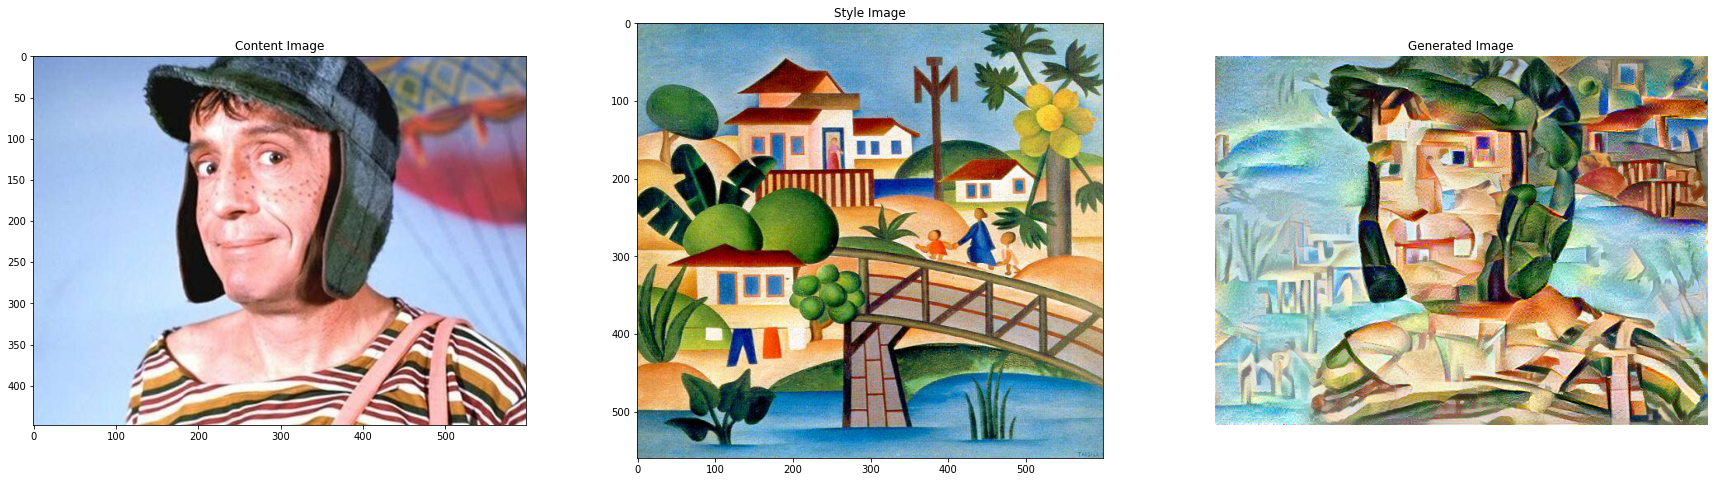

In [20]:
fig , (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (30, 8))

ax1.imshow(tf.squeeze(content_image, axis = 0))
ax1.set_title("Content Image")


ax2.imshow(tf.squeeze(style_image, axis = 0))
ax2.set_title("Style Image")


ax3.imshow(tf.squeeze(new_image, axis = 0))
ax3.set_title("Generated Image")

plt.axis("off")